## Comparing the predict and orchestrate endpoints to local inference

In [1]:
import torch
import torchvision
import torchdata
import random
import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")
# Set the random seed
seed=0 # we need to set this for torch datapipe separately
random.seed(seed)

In [2]:
model_path = "/slickformer/data/models/2023_02_18_00_38_07_4cls_rn152_pr512_px1024_1440min_maskrcnn_scripting_cpu_model.pt"
scripted_model = torch.jit.load(model_path)

## Parsing configs

In [ ]:
import httpx
import configparser
import base64
import os

# parses secrets so we don't expose them in the notebook
config = configparser.ConfigParser()
config.read('../.secrets')
config = config['secrets']
os.environ['API_KEY'] = config['CERULEAN_API_KEY']
os.environ['GS_ACCESS_KEY_ID'] = config['GS_ACCESS_KEY_ID']
os.environ['GS_SECRET_ACCESS_KEY'] = config['GS_SECRET_ACCESS_KEY']
TITILER_URL=config['TITILER_URL']
INFERENCE_URL=config['INFERENCE_URL']
AUX_INFRA_DISTANCE=config['AUX_INFRA_DISTANCE']

### Saving out a test tile from a test scene to test the predict endpoint

In [9]:
import rasterio
from rio_tiler_pds.sentinel.aws import S1L1CReader

In [10]:
coinc_scene_ids = ['S1B_IW_GRDH_1SDV_20200806T162023_20200806T162048_022805_02B484_06D3',
  'S1A_IW_GRDH_1SDV_20210213T111635_20210213T111700_036570_044BAA_87EE',
  'S1B_IW_GRDH_1SDV_20210707T172027_20210707T172050_027691_034E02_CA71',
  'S1B_IW_GRDH_1SDV_20201018T183430_20201018T183455_023871_02D5CE_E8CD',
  'S1A_IW_GRDH_1SDV_20210523T005625_20210523T005651_038008_047C68_FE94']

In [11]:
recents_scene_ids = ["S1A_IW_GRDH_1SDV_20230319T115131_20230319T115159_047713_05BB3B_F9EB",
 "S1A_IW_GRDH_1SDV_20230323T111621_20230323T111646_047770_05BD30_7FF2",
 "S1A_IW_GRDH_1SDV_20230326T232010_20230326T232035_047822_05BEDD_872B",
 "S1A_IW_GRDH_1SDV_20230328T021522_20230328T021547_047838_05BF72_B60D",
 "S1A_IW_GRDH_1SDV_20230402T203727_20230402T203756_047922_05C245_5FCF"]

In [7]:
import rasterio
from rasterio.plot import reshape_as_raster
import numpy as np

scene_id = "S1A_IW_GRDH_1SDV_20230326T232010_20230326T232035_047822_05BEDD_872B"
coord_of_interest_with_zoom = (-79.50391 , 26.64127, 9)
# coord_of_interest_with_zoom = (-55.3473, 51.8736, 9)

def get_tile_spoof_3_channel(scene_id, coord_of_interest_with_zoom):
    with rasterio.Env(AWS_REQUEST_PAYER="requester"):
        with S1L1CReader(scene_id) as sentinel:
            print(sentinel.bands)

            print(sentinel.bounds)

            print(type(sentinel.productInfo))

            print(sentinel._get_band_url("vv"))
            tile = sentinel.tms.tile(*coord_of_interest_with_zoom)
            img = sentinel.tile(*tile, bands="vv", tilesize=512) #lon, lat, zoom
            img.rescale(((17.0, 608.0),)) # inplace

    with open(f"../data/{scene_id}_with_slick_512_512_3band_{coord_of_interest_with_zoom[0]}_{coord_of_interest_with_zoom[1]}_{coord_of_interest_with_zoom[2]}.tif", "wb") as f:
        img.data = np.repeat(img.data, 3,0)
        f.write(img.render(img_format="GTiff", add_mask=False, compress="DEFLATE"))
    return img

In [8]:
img = get_tile_spoof_3_channel(scene_id, coord_of_interest_with_zoom)

('vv', 'vh')
(-80.1802809752676, 25.101029868025403, -77.40092379940506, 27.018484920245537)
<class 'dict'>
s3://sentinel-s1-l1c/GRD/2023/3/26/IW/DV/S1A_IW_GRDH_1SDV_20230326T232010_20230326T232035_047822_05BEDD_872B/measurement/iw-vv.tiff


# Getting 3 channel tile with infra distance and ship vessel density for local inference

In [1]:
import sys
sys.path.insert(0,"../cerulean-cloud-copy/")
import rasterio
from rasterio.plot import show
from cerulean_cloud.cloud_run_orchestrator.clients import *
from cerulean_cloud.cloud_run_orchestrator.handler import from_tiles_get_offset_shape, from_bounds_get_offset_bounds
from cerulean_cloud.titiler_client import TitilerClient
from cerulean_cloud.tiling import TMS as tiler
from cerulean_cloud.tiling import from_base_tiles_create_offset_tiles

sceneid="S1A_IW_GRDH_1SDV_20200729T034859_20200729T034924_033664_03E6D3_93EF"

titiler_client = TitilerClient(url=TITILER_URL)
bounds = await titiler_client.get_bounds(sceneid)
stats = await titiler_client.get_statistics(sceneid, band="vv")
base_tiles = list(tiler.tiles(*bounds, [9], truncate=False))
offset_image_shape = from_tiles_get_offset_shape(base_tiles, scale=2)
offset_tiles_bounds = from_base_tiles_create_offset_tiles(base_tiles)
offset_bounds = from_bounds_get_offset_bounds(offset_tiles_bounds)

client = CloudRunInferenceClient(url=INFERENCE_URL, titiler_client=titiler_client, sceneid=sceneid, offset_bounds=offset_bounds, offset_image_shape=offset_image_shape, aux_datasets=["ship_density", AUX_INFRA_DISTANCE])

In [1]:
tile = base_tiles[0]
print(TMS.bounds(tile)) # we can use this to filter tiles by a point

tile = base_tiles[0]

rescale = (stats["min"], stats["max"])

img_array = await client.titiler_client.get_base_tile(
    sceneid=client.sceneid, tile=tile, scale=client.scale, rescale=rescale
)
img_array = reshape_as_raster(img_array)
bounds = list(TMS.bounds(tile))
with client.aux_datasets.open() as src:
    window = rasterio.windows.from_bounds(*bounds, transform=src.transform)
    height, width = img_array.shape[1:]
    aux_ds = src.read(window=window, out_shape=(height, width))

img_array = np.concatenate([img_array[0:1, :, :], aux_ds], axis=0)

img_array.shape

In [60]:
test1 = "../data/tile_with_slick_512_512_3band.png"
test2 = "../data/S1A_IW_GRDH_1SDV_20230326T232010_20230326T232035_047822_05BEDD_872B_with_slick_512_512_3band_-79.50391_26.64127_9.tif"

In [61]:
test_scenes = [test2] 

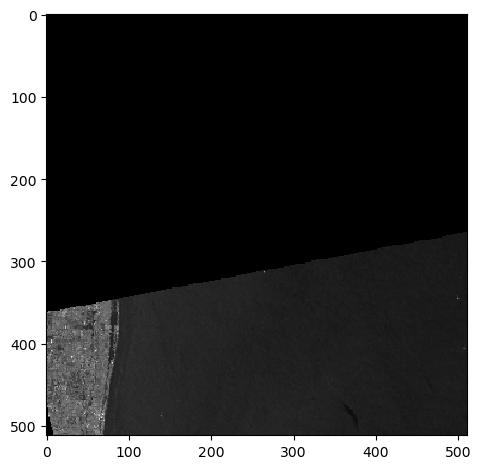

In [62]:
import skimage.io as skio
arr1 = skio.imread(test2)
skio.imshow(arr1)

In [63]:
from ceruleanml.data_pipeline import put_image_in_dict, channel_first_norm_to_tensor
source_pipe = torchdata.datapipes.iter.IterableWrapper(iterable=test_scenes)


source = (source_pipe 
    .read_tiff()
    .map(put_image_in_dict)
    .map(channel_first_norm_to_tensor)
)

### running local inference

In [64]:
# time is an issue where there are lots of slicks
from ceruleanml.inference import mrcnn_3_class_inference
from ceruleanml.data_creation import class_dict

bbox_conf_threshold = .2
mask_conf_threshold=.2
input_size=2000
for idict in source:
    pred_dict_thresholded, pred_dict = mrcnn_3_class_inference([idict['image']], scripted_model, bbox_conf_threshold, mask_conf_threshold, input_size=input_size)
    pred_dict_thresholded_nms , pred_dict = mrcnn_3_class_inference([idict['image']], scripted_model, bbox_conf_threshold, mask_conf_threshold, input_size=input_size, interclass_nms_threshold=.5)

This is just to confirm that mAP is 1 for the same geometries

In [65]:
from torchmetrics import detection

m = detection.mean_ap.MeanAveragePrecision(box_format='xyxy', iou_type='bbox', iou_thresholds=[.5], rec_thresholds=None, max_detection_thresholds=None, class_metrics=True)

m.update(preds=[pred_dict_thresholded_nms], target=[pred_dict_thresholded_nms])

from pprint import pprint
pprint(m.compute())

{'map': tensor(-1.),
 'map_50': tensor(-1.),
 'map_75': tensor(-1),
 'map_large': tensor(-1.),
 'map_medium': tensor(-1.),
 'map_per_class': tensor([]),
 'map_small': tensor(-1.),
 'mar_1': tensor(-1.),
 'mar_10': tensor(-1.),
 'mar_100': tensor(-1.),
 'mar_100_per_class': tensor([]),
 'mar_large': tensor(-1.),
 'mar_medium': tensor(-1.),
 'mar_small': tensor(-1.)}


In [66]:
pred_dict_thresholded_nms['masks']

tensor([], dtype=torch.uint8)

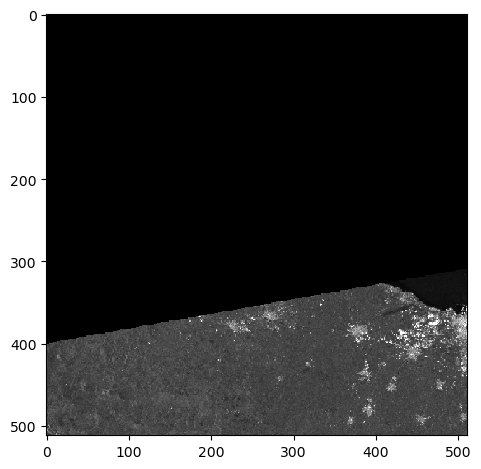

In [39]:
skio.imshow(arr1)

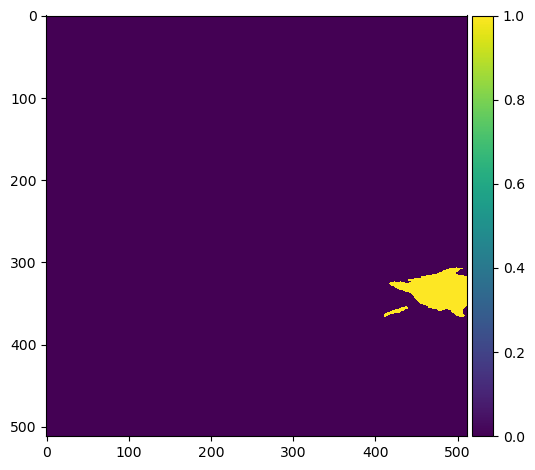

In [38]:
skio.imshow(pred_dict_thresholded_nms['masks'].numpy()[0])

## Testing the image on the predict URL and comparing to the local inference we ran above

In [44]:
import httpx
import configparser
import base64
# parses secrets so we don't expose them in the notebook
config = configparser.ConfigParser()
config.read('../.secrets')
config = config['secrets']
# reads image as bytes, converts bytes to string so it can be sent as a post request
with open(test_scenes[0], 'rb') as f:
    byte_string = f.read()
    base64_string = base64.b64encode(byte_string).decode('utf-8')
# we format the payload and headers according to what the docs expect
# docs are at f"{config['CERULEAN_STAGING_URL']}/docs"
predict_url = f"{config['CERULEAN_OFFSET_STAGING_URL']}/predict"
payload = {"stack": [{"image": base64_string, "bounds":[ 0,0,0,0 ]}]}
headers = {"Authorization": f"Bearer {config['CERULEAN_API_KEY']}"}
response = httpx.post(predict_url, json=payload, headers=headers, timeout=None)

In [47]:
test_scenes[0]

'../data/S1A_IW_GRDH_1SDV_20230101T165002_20230101T165027_046593_059574_607E_with_slick_512_512_3band_15.9553_43.3354_9.tif'

In [46]:
response

<Response [500 Internal Server Error]>

In [91]:
import json
with open(f'{scene_id + "_predict"}.geojson', 'w') as f:
    json.dump(response.json()['stack'][0]['features'][0], f)

In [92]:
print(pred_dict_thresholded_nms['labels'], pred_dict_thresholded_nms['scores'])

tensor([1]) tensor([0.6029])


Test scene 1 and test scene 2 both match. we can also run the orchestrator on the whole scene, visualize the resulting geojsons in qgis, and run the predict endpoint on tiles that intersect those geojsons to check other tiles.

In [93]:
orchestrate_url = f"{config['CERULEAN_ORCHESTRATE_STAGING_URL']}/orchestrate"
scene_id = "S1A_IW_GRDH_1SDV_20230101T164912_20230101T164937_046593_059574_A79E"
payload = {
  "sceneid": scene_id
}

headers = {"Authorization": f"Bearer {config['CERULEAN_API_KEY']}"}
response = httpx.post(orchestrate_url, json=payload, headers=headers, timeout=None)

In [94]:
response

<Response [200 OK]>

In [95]:
list(response.json().keys())[0:3]

['classification_base', 'classification_offset', 'classification_merged']

## Saving out the results from the orchestrator

In [96]:
import json
for i in list(response.json().keys())[0:3]:
    with open(f'{scene_id + "_" +i}.geojson', 'w') as f:
        json.dump(response.json()[i], f)